In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import numpy as np

def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

random_state = 42

In [27]:
df_magistr_ratings = read_dataset('../../data/datasets/subjects_magistr_ratings.csv')
df_bak_spec_ratings = read_dataset("../../data/datasets/subjects_bak_spec_ratings.csv")

In [29]:
df_numeric = df_bak_spec_ratings.select_dtypes(include=[np.number])

# Удаляем столбцы, где много пропусков или мало вариативности
df_numeric.dropna(inplace=True)

# Шаг 1: Вычисляем корреляционную матрицу
corr_matrix = df_numeric.corr().abs()

# Шаг 2: Убираем диагональ (сам с собой), чтобы не мешало
np.fill_diagonal(corr_matrix.values, 0)

# Шаг 3: Преобразуем матрицу в список пар (i, j) с их значениями
pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # только верхний треугольник
    .stack()
    .sort_values(ascending=False)
)

# Шаг 4: Берём топ-10
top_pairs = pairs.head(10)

for (col1, col2), value in top_pairs.items():
    print(f"{col1} ↔ {col2}: {value:.4f}")

Общее количество долгов ↔ Рейтинг студента: 0.9658
Категория конкурса БВИ ↔ олимпиада из перечня, утвержденного МОН РФ (ОШ): 0.9568
Полных лет на момент поступления ↔ Прошло лет с окончания уч. заведения: 0.8682
Рейтинг студента ↔ Позиция студента в рейтинге: 0.8419
Общее количество долгов ↔ Позиция студента в рейтинге: 0.8168
Отдельная квота ↔ Боевые действия: 0.8147
БВИ ↔ Категория конкурса БВИ: 0.7610
БВИ ↔ олимпиада из перечня, утвержденного МОН РФ (ОШ): 0.7281
Особая квота ↔ Инвалиды: 0.7202
Cумма баллов испытаний ↔ БВИ: 0.7156


In [66]:
df_magistr_ratings['Рейтинг студента', 'Позиция студента в рейтинге']

KeyError: ('Рейтинг студента', 'Позиция студента в рейтинге')

In [9]:
X_bak_spec = df_bak_spec_ratings.drop(columns=["Таргет"])
y_bak_spec = df_bak_spec_ratings["Таргет"]

X_train_bak_spec, X_test_bak_spec, y_train_bak_spec, y_test_bak_spec = train_test_split(
    X_bak_spec,
    y_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_magistr = df_magistr_ratings.drop(columns=["Таргет"])
y_magistr = df_magistr_ratings["Таргет"]

X_train_magistr, X_test_magistr, y_train_magistr, y_test_magistr = train_test_split(
    X_magistr,
    y_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       117
           1       0.36      0.94      0.52        17

    accuracy                           0.78       134
   macro avg       0.68      0.85      0.69       134
weighted avg       0.91      0.78      0.82       134



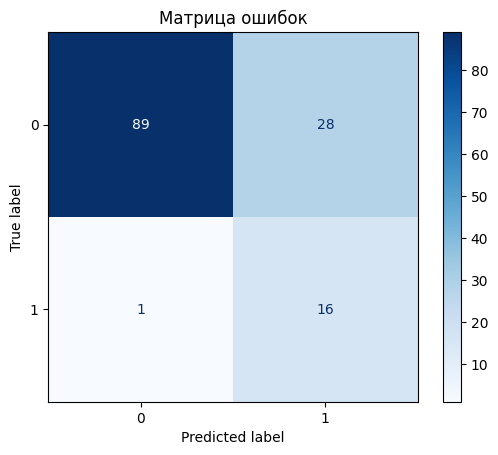

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_magistr, y_train_magistr)

y_pred_magistr = grid_search.predict(X_test_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_magistr_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_magistr, y_pred_magistr))

cm = confusion_matrix(y_test_magistr, y_pred_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [13]:
clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_magistr.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

                                            feature  importance
41                      Позиция студента в рейтинге    0.679519
13                                 Рейтинг студента    0.070803
0                                         Приоритет    0.051250
5                                          Контракт    0.048719
9                  Полных лет на момент поступления    0.044004
15                             fromSverdlovskRegion    0.035256
12                          Общее количество долгов    0.020537
11                        Общее количество пересдач    0.020337
1                            Cумма баллов испытаний    0.017074
8                                               Пол    0.012500
6                             Нуждается в общежитии    0.000000
7                      Иностранный абитуриент (МОН)    0.000000
3                           Балл за инд. достижения    0.000000
4                            Категория конкурса БВИ    0.000000
2                                       

{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       271
           1       0.77      0.71      0.74        52

    accuracy                           0.92       323
   macro avg       0.86      0.84      0.85       323
weighted avg       0.92      0.92      0.92       323



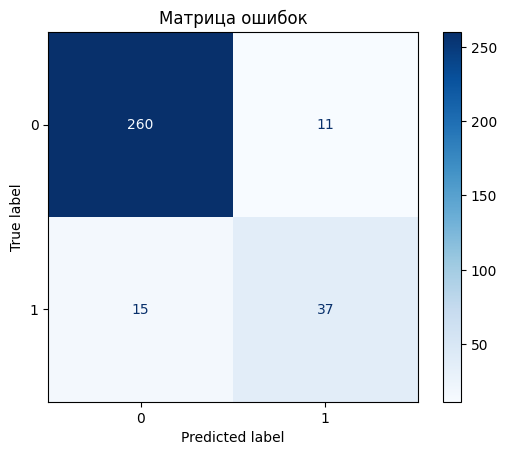

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_bak_spec, y_train_bak_spec)

y_pred_bak_spec = grid_search.predict(X_test_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_bak_spec_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_bak_spec, y_pred_bak_spec))

cm = confusion_matrix(y_test_bak_spec, y_pred_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [15]:
clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_bak_spec.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

                                            feature  importance
12                          Общее количество долгов    0.703899
42                      Позиция студента в рейтинге    0.114366
13                                 Рейтинг студента    0.074006
1                            Cумма баллов испытаний    0.042121
24                                       Специалист    0.026103
16                          Human Development Index    0.014820
9                  Полных лет на момент поступления    0.010368
0                                         Приоритет    0.010094
23                                     Очно-заочная    0.004224
2                                               БВИ    0.000000
3                           Балл за инд. достижения    0.000000
10             Прошло лет с окончания уч. заведения    0.000000
8                                               Пол    0.000000
7                      Иностранный абитуриент (МОН)    0.000000
6                             Нуждается 

In [60]:
df_magistr_without_rating = df_magistr_ratings.drop(columns=["Рейтинг студента", 'Категория конкурса БВИ'])
df_bak_spec_without_rating = df_bak_spec_ratings.drop(columns=["Рейтинг студента", 'Категория конкурса БВИ'])

In [61]:


X_bak_spec = df_bak_spec_without_rating.drop(columns=["Таргет"])
y_bak_spec = df_bak_spec_without_rating["Таргет"]

X_train_bak_spec, X_test_bak_spec, y_train_bak_spec, y_test_bak_spec = train_test_split(
    X_bak_spec,
    y_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_magistr = df_magistr_without_rating.drop(columns=["Таргет"])
y_magistr = df_magistr_without_rating["Таргет"]

X_train_magistr, X_test_magistr, y_train_magistr, y_test_magistr = train_test_split(
    X_magistr,
    y_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       117
           1       0.36      0.94      0.52        17

    accuracy                           0.78       134
   macro avg       0.68      0.85      0.69       134
weighted avg       0.91      0.78      0.82       134



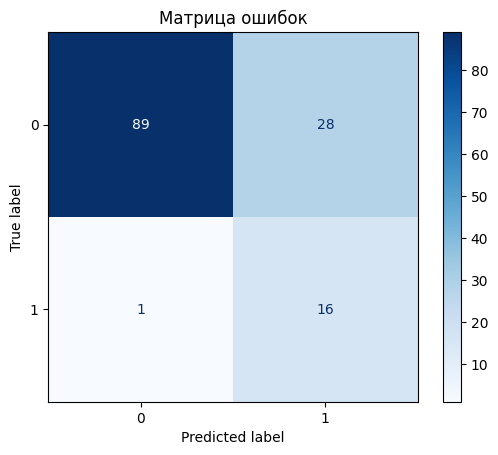

In [62]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5, 10],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_magistr, y_train_magistr)

y_pred_magistr = grid_search.predict(X_test_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_magistr_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_magistr, y_pred_magistr))

cm = confusion_matrix(y_test_magistr, y_pred_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [63]:
clf = grid_search.best_estimator_

importances = clf.named_steps['clf'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': X_train_magistr.columns,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importances)

                                            feature  importance
39                      Позиция студента в рейтинге    0.749363
0                                         Приоритет    0.051250
8                  Полных лет на момент поступления    0.048907
4                                          Контракт    0.048719
13                             fromSverdlovskRegion    0.035256
10                        Общее количество пересдач    0.020337
1                            Cумма баллов испытаний    0.018033
11                          Общее количество долгов    0.015635
7                                               Пол    0.012500
5                             Нуждается в общежитии    0.000000
2                                               БВИ    0.000000
3                           Балл за инд. достижения    0.000000
6                      Иностранный абитуриент (МОН)    0.000000
9              Прошло лет с окончания уч. заведения    0.000000
14                          Human Develo

{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       271
           1       0.84      0.69      0.76        52

    accuracy                           0.93       323
   macro avg       0.89      0.83      0.86       323
weighted avg       0.93      0.93      0.93       323



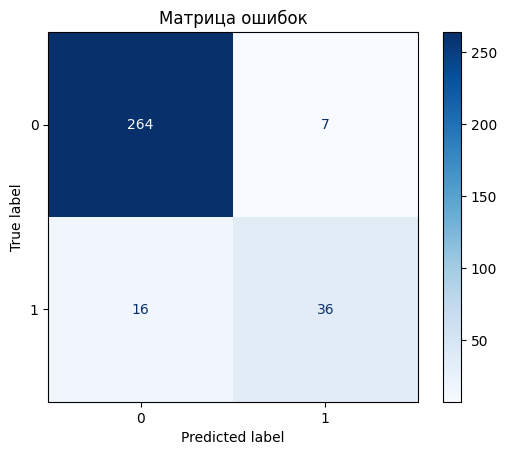

In [64]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_bak_spec, y_train_bak_spec)

y_pred_bak_spec = grid_search.predict(X_test_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_bak_spec_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_bak_spec, y_pred_bak_spec))

cm = confusion_matrix(y_test_bak_spec, y_pred_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [49]:
df_magistr_without_rating = df_magistr_ratings.drop(columns=["Позиция студента в рейтинге"])
df_bak_spec_without_rating = df_bak_spec_ratings.drop(columns=["Позиция студента в рейтинге"])

In [50]:
X_bak_spec = df_bak_spec_without_rating.drop(columns=["Таргет"])
y_bak_spec = df_bak_spec_without_rating["Таргет"]

X_train_bak_spec, X_test_bak_spec, y_train_bak_spec, y_test_bak_spec = train_test_split(
    X_bak_spec,
    y_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_magistr = df_magistr_without_rating.drop(columns=["Таргет"])
y_magistr = df_magistr_without_rating["Таргет"]

X_train_magistr, X_test_magistr, y_train_magistr, y_test_magistr = train_test_split(
    X_magistr,
    y_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86       117
           1       0.35      0.88      0.50        17

    accuracy                           0.78       134
   macro avg       0.66      0.82      0.68       134
weighted avg       0.90      0.78      0.81       134



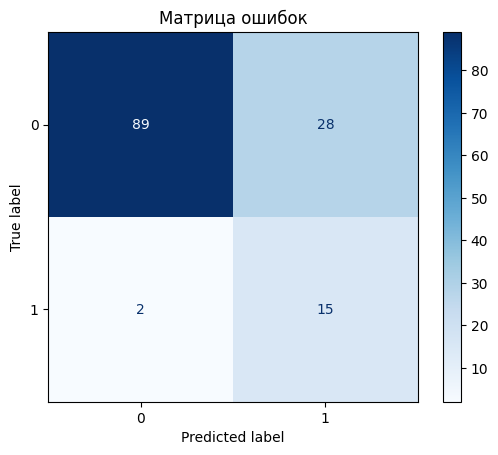

In [51]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_magistr, y_train_magistr)

y_pred_magistr = grid_search.predict(X_test_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_magistr_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_magistr, y_pred_magistr))

cm = confusion_matrix(y_test_magistr, y_pred_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       271
           1       0.81      0.67      0.74        52

    accuracy                           0.92       323
   macro avg       0.88      0.82      0.85       323
weighted avg       0.92      0.92      0.92       323



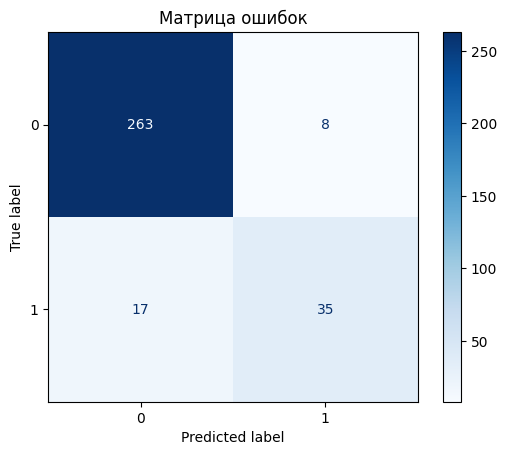

In [52]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_bak_spec, y_train_bak_spec)

y_pred_bak_spec = grid_search.predict(X_test_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_bak_spec_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_bak_spec, y_pred_bak_spec))

cm = confusion_matrix(y_test_bak_spec, y_pred_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [45]:
df_magistr_without_rating = df_magistr_ratings.drop(columns=["Общее количество долгов"])
df_bak_spec_without_rating = df_bak_spec_ratings.drop(columns=["Общее количество долгов"])

In [46]:
X_bak_spec = df_bak_spec_without_rating.drop(columns=["Таргет"])
y_bak_spec = df_bak_spec_without_rating["Таргет"]

X_train_bak_spec, X_test_bak_spec, y_train_bak_spec, y_test_bak_spec = train_test_split(
    X_bak_spec,
    y_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_magistr = df_magistr_without_rating.drop(columns=["Таргет"])
y_magistr = df_magistr_without_rating["Таргет"]

X_train_magistr, X_test_magistr, y_train_magistr, y_test_magistr = train_test_split(
    X_magistr,
    y_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf': DecisionTreeClassifier(), 'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        min_samples_leaf=5,
                                        min_samples_split=5))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       117
           1       0.36      0.94      0.52        17

    accuracy                           0.78       134
   macro avg       0.68      0.85      0.69       134
weighted avg       0.91      0.78      0.82       134



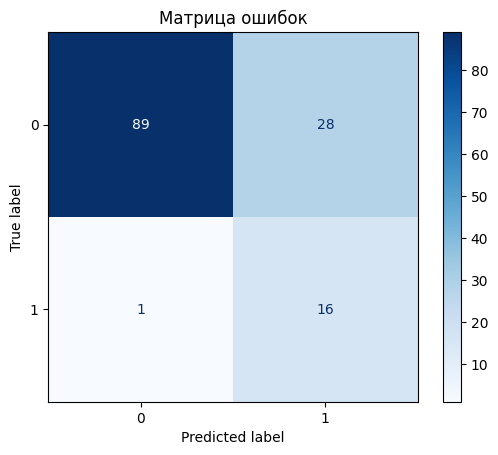

In [47]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_magistr, y_train_magistr)

y_pred_magistr = grid_search.predict(X_test_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_magistr_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_magistr, y_pred_magistr))

cm = confusion_matrix(y_test_magistr, y_pred_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

{'clf': DecisionTreeClassifier(), 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(max_depth=3))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       271
           1       0.78      0.69      0.73        52

    accuracy                           0.92       323
   macro avg       0.86      0.83      0.84       323
weighted avg       0.92      0.92      0.92       323



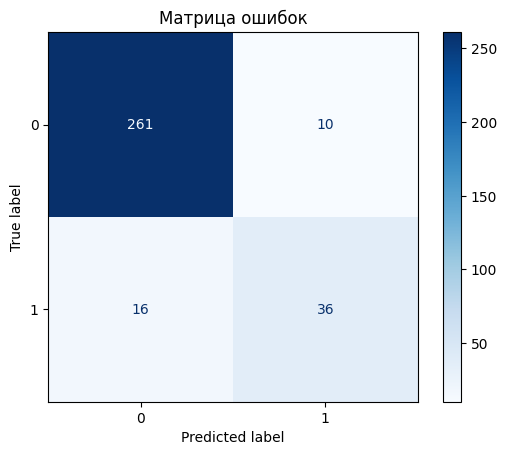

In [48]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier())
])

param_grid = [
    {
        'clf': [DecisionTreeClassifier()],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [2, 3, 5, 10, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        'clf__min_samples_split': [2, 5, 10, 12, 15],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_bak_spec, y_train_bak_spec)

y_pred_bak_spec = grid_search.predict(X_test_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/dec_tree_model_bak_spec_with_ratings.pkl')

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации:\n", classification_report(y_test_bak_spec, y_pred_bak_spec))

cm = confusion_matrix(y_test_bak_spec, y_pred_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()